# **1. PERKENALAN**

Final Project Hacktive8 Bacth 011

Kelompok        : 2

Anggota         :

- Al Izhar Iqrami
- Irfan Fahmuddin Maru'f
- Ridha Fuady
- William Putra




# **2. IMPORT LIBRARY**

In [3]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import urllib

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from PIL import Image
from IPython.display import display, HTML

# **3. DATA LOADING**

In [4]:
cols = [0]
df = pd.read_csv('fashion.csv')
df.drop(df.columns[cols], axis=1,inplace=True)
df2 = pd.read_csv('pake.csv')
df2.drop(df2.columns[cols], axis=1,inplace=True)

## Copy Dataset

In [5]:
fashion = df.copy()
ratings = df2.copy()

In [6]:
fashion.head(3)

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,1,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,2,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,3,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...


In [7]:
ratings.head(3)

,user_id,ProductId,rating
0,5641,1545,1
1,6937,2841,1
2,5956,1860,4


# **4. Exploratory Data Analysis**

## Melihat Perbandingan Image

In [10]:
augmentedDataframe = pd.DataFrame({
    'filename': fashion['Image'],
    'type': fashion['SubCategory']
})

# total number of entries in the dataframe
total_row = len(augmentedDataframe)
print('total row count: ', total_row)

augmentedDataframe.head(5)

total row count:  2906


,filename,type
0,42419.jpg,Topwear
1,34009.jpg,Topwear
2,40143.jpg,Topwear
3,23623.jpg,Topwear
4,47154.jpg,Bottomwear


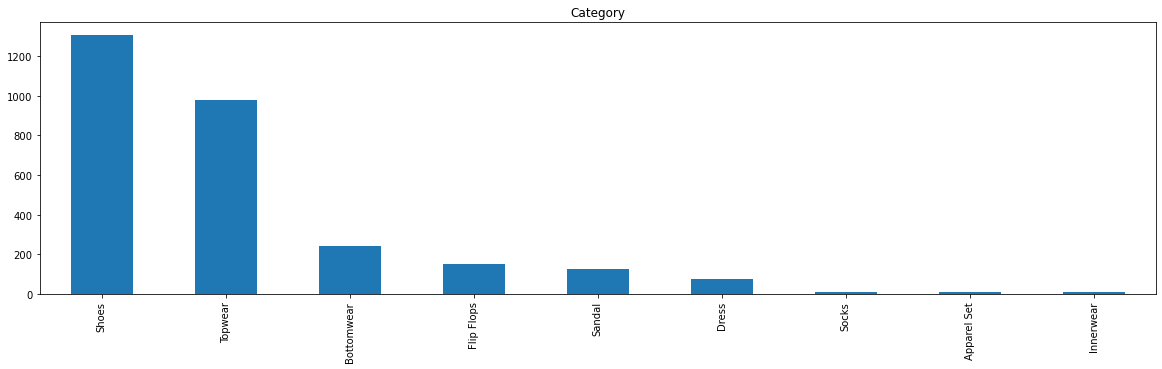

In [14]:
plt.figure(figsize=(20,5))
augmentedDataframe['type'].value_counts().plot(kind='bar',x='type',y='filename')
plt.title('Category')
plt.show()

## Check Persentase Data Berdasarkan Jenis Fashion

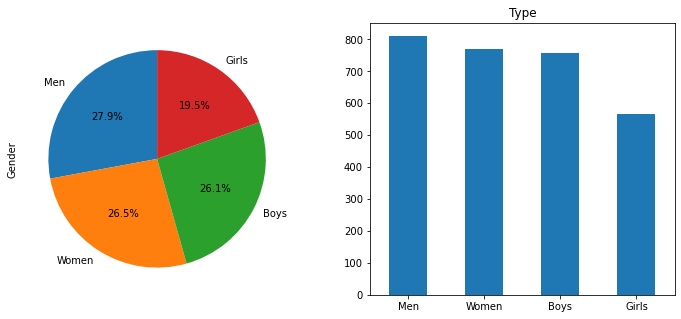

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
fashion['Gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[0])
fashion['Gender'].value_counts().plot(kind='bar', ax=axs[1])
plt.title('Type')
plt.xticks(rotation = 0)
plt.show()

# **5. PREPROCESSING**

In [40]:
fashion.duplicated().sum()

0

## Check Missing Value

In [41]:
cek = pd.DataFrame(fashion.isnull().sum(), columns=['No. of missing values'])
cek['% missing_values'] = (cek/len(fashion)).round(2)*100
cek

,No. of missing values,% missing_values
ProductId,0,0.0
Gender,0,0.0
Category,0,0.0
SubCategory,0,0.0
ProductType,0,0.0
Colour,0,0.0
Usage,0,0.0
ProductTitle,0,0.0
Image,0,0.0
ImageURL,0,0.0


## Split Train & Val

In [15]:
train, val = train_test_split(ratings, test_size=0.1,random_state=42)

dim_product =ratings.ProductId.max()+1
dim_users =ratings.user_id.max()+1

In [16]:
y_train = (train.rating - ratings.rating.min()) / (ratings.rating.max() - ratings.rating.min())
y_val = (val.rating - ratings.rating.min()) / (ratings.rating.max() - ratings.rating.min())

## Model Definition

In [17]:
# Layers Embeding for Book
fashion_input = Input(shape=(1,), name="Book-Input")    # Input layer
fashion_embedding = Embedding(dim_product, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="Fashion-Embedding")(fashion_input)
fashion_vec = Flatten(name="Flatten-Books")(fashion_embedding)

# Layers Embeding for User
user_input = Input(shape=(1,), name="User-Input")       # Input layer
user_embedding = Embedding(dim_users, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Dot Product
prod = Dot(name="Dot-Product", axes=1)([fashion_vec, user_vec])

## Evaluation Training

In [18]:
dense = Dense(1,activation='relu')(prod)

model_1 = Model([user_input, fashion_input], dense)          # Urutan tidak boleh terbalik harus user_input kemudian book_input, boleh terbalik yang penting konsisten dengan codingan sebelumnya
model_1.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Book-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Fashion-Embedding (Embedding)  (None, 1, 50)        145350      ['Book-Input[0][0]']             
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 50)        400050      ['User-Input[0][0]']             
                                                                                              

In [19]:
history_1 = model_1.fit(x=[train.user_id.values,train.ProductId.values], 
                    y=y_train.values, 
                    batch_size=64, 
                    epochs=30, 
                    verbose=1, 
                    validation_data=([val.user_id.values,val.ProductId.values], y_val.values))

Epoch 1/30
940/940 [==============================] - 6s 6ms/step - loss: 0.1802 - accuracy: 0.2015 - val_loss: 0.1245 - val_accuracy: 0.2057
Epoch 2/30
940/940 [==============================] - 5s 6ms/step - loss: 0.1010 - accuracy: 0.3686 - val_loss: 0.1342 - val_accuracy: 0.1993
Epoch 3/30
940/940 [==============================] - 5s 5ms/step - loss: 0.0186 - accuracy: 0.4027 - val_loss: 0.1448 - val_accuracy: 0.1984
Epoch 4/30
940/940 [==============================] - 5s 6ms/step - loss: 0.0068 - accuracy: 0.4029 - val_loss: 0.1431 - val_accuracy: 0.1979
Epoch 5/30
940/940 [==============================] - 5s 5ms/step - loss: 0.0065 - accuracy: 0.4029 - val_loss: 0.1440 - val_accuracy: 0.2008
Epoch 6/30
940/940 [==============================] - 5s 5ms/step - loss: 0.0087 - accuracy: 0.4028 - val_loss: 0.1441 - val_accuracy: 0.1978
Epoch 7/30
940/940 [==============================] - 5s 5ms/step - loss: 0.0116 - accuracy: 0.4028 - val_loss: 0.1434 - val_accuracy: 0.1994
Epoch 

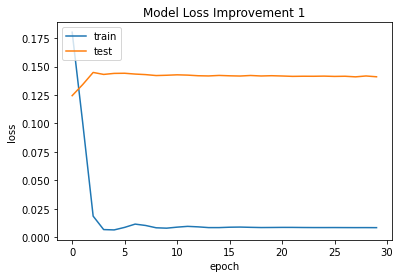

In [20]:
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model Loss Improvement 1")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# **6. MODEL IMPROFEMENT** 

## Improvement 1

In [21]:
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)]

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train)

In [22]:
# Layers Embeding for Book
fashion_input2 = Input(shape=(1,), name="Book-Input")    # Input layer
fashion_embedding2 = Embedding(dim_product, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="Fashion-Embedding")(fashion_input2)
fashion_vec2 = Flatten(name="Flatten-Books")(fashion_embedding2)

# Layers Embeding for User
user_input2 = Input(shape=(1,), name="User-Input")       # Input layer
user_embedding2 = Embedding(dim_users, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="User-Embedding")(user_input2)
user_vec2 = Flatten(name="Flatten-Users")(user_embedding2)

# Dot Product
prod2 = Dot(name="Dot-Product", axes=1)([fashion_vec2, user_vec2])

In [23]:
prod2 = Dot(name="Dot-Product", axes=1, normalize = True)([fashion_vec2, user_vec2])

hidden5 = Dense(128, activation='relu')(prod2)
hidden6 = BatchNormalization()(hidden5)
hidden7 = Dropout(rate=0.1)(hidden6)
hidden8 = Dense(32, activation='relu')(hidden7)
hidden9 = BatchNormalization()(hidden8)

output = Dense(1, activation='relu')(hidden9)
model_imp2 = Model([user_input2, fashion_input2], output) 
model_imp2.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

model_imp2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Book-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Fashion-Embedding (Embedding)  (None, 1, 50)        145350      ['Book-Input[0][0]']             
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 50)        400050      ['User-Input[0][0]']             
                                                                                            

In [24]:
history_imp2 = model_imp2.fit(x=[train.user_id.values,train.ProductId.values], 
                    y=y_train.values, 
                    batch_size=64, 
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks,
                    validation_data=([val.user_id.values,val.ProductId.values], y_val.values))


Epoch 1/20
940/940 [==============================] - 7s 6ms/step - loss: 0.1578 - accuracy: 0.2018 - val_loss: 0.1264 - val_accuracy: 0.1982
Epoch 2/20
940/940 [==============================] - 6s 7ms/step - loss: 0.1297 - accuracy: 0.2019 - val_loss: 0.1252 - val_accuracy: 0.2063
Epoch 3/20
940/940 [==============================] - 7s 7ms/step - loss: 0.1277 - accuracy: 0.2120 - val_loss: 0.1372 - val_accuracy: 0.1905
Epoch 4/20
940/940 [==============================] - 7s 7ms/step - loss: 0.1224 - accuracy: 0.2433 - val_loss: 0.1402 - val_accuracy: 0.1923
Epoch 5/20
940/940 [==============================] - 7s 7ms/step - loss: 0.1114 - accuracy: 0.2741 - val_loss: 0.1344 - val_accuracy: 0.1934
Epoch 5: early stopping


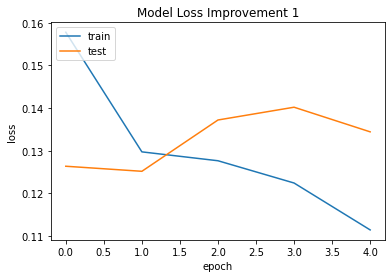

In [26]:
plt.plot(history_imp2.history["loss"])
plt.plot(history_imp2.history["val_loss"])
plt.title("Model Loss Improvement 1")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Improvement 2

In [27]:
# Layers Embeding for Book
fashion_input3 = Input(shape=(1,), name="Book-Input")    # Input layer
fashion_embedding3 = Embedding(dim_product, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="Fashion-Embedding")(fashion_input3)
fashion_vec3 = Flatten(name="Flatten-Books")(fashion_embedding3)

# Layers Embeding for User
user_input3 = Input(shape=(1,), name="User-Input")       # Input layer
user_embedding3 = Embedding(dim_users, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="User-Embedding")(user_input3)
user_vec3 = Flatten(name="Flatten-Users")(user_embedding3)

# Dot Product
prod4 = Dot(name="Dot-Product", axes=1)([fashion_vec3, user_vec3])

In [28]:
prod4 = Dot(name="Dot-Product", axes=1, normalize = True)([fashion_vec3, user_vec3])

hid1 = Dense(7, activation='relu', kernel_initializer= 'he_normal', use_bias=False)(prod4)
hid2 = BatchNormalization()(hid1)
hid3 = Dropout(rate=0.3)(hid2)

hid4 = Dense(5, activation='relu', kernel_initializer= 'he_normal', use_bias=False)(hid3)
hid5 = BatchNormalization()(hid4)
hid6 = Dropout(rate=0.3)(hid5)

hid7 = Dense(3, activation='relu', kernel_initializer= 'he_normal', use_bias=False)(hid6)
hid8 = BatchNormalization()(hid7)
hid9 = Dropout(rate=0.3)(hid8)

output = Dense(1, activation='relu')(hid9)
model_imp3 = Model([user_input3, fashion_input3], output) 
model_imp3.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

model_imp3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Book-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Fashion-Embedding (Embedding)  (None, 1, 50)        145350      ['Book-Input[0][0]']             
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 50)        400050      ['User-Input[0][0]']             
                                                                                            

In [29]:
history_imp3 = model_imp3.fit(x=[train.user_id.values,train.ProductId.values], 
                    y=y_train.values, 
                    batch_size=64, 
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks,
                    validation_data=([val.user_id.values,val.ProductId.values], y_val.values))


Epoch 1/20
940/940 [==============================] - 7s 6ms/step - loss: 0.5225 - accuracy: 0.2014 - val_loss: 0.3668 - val_accuracy: 0.2057
Epoch 2/20
940/940 [==============================] - 5s 5ms/step - loss: 0.3318 - accuracy: 0.2015 - val_loss: 0.3067 - val_accuracy: 0.2057
Epoch 3/20
940/940 [==============================] - 6s 6ms/step - loss: 0.2286 - accuracy: 0.2033 - val_loss: 0.1266 - val_accuracy: 0.2006
Epoch 4/20
940/940 [==============================] - 6s 6ms/step - loss: 0.1407 - accuracy: 0.2031 - val_loss: 0.1246 - val_accuracy: 0.1909
Epoch 5/20
940/940 [==============================] - 6s 7ms/step - loss: 0.1303 - accuracy: 0.2029 - val_loss: 0.1246 - val_accuracy: 0.1915
Epoch 6/20
940/940 [==============================] - 6s 6ms/step - loss: 0.1280 - accuracy: 0.2071 - val_loss: 0.1246 - val_accuracy: 0.1917
Epoch 7/20
940/940 [==============================] - 6s 6ms/step - loss: 0.1271 - accuracy: 0.2055 - val_loss: 0.1244 - val_accuracy: 0.2057
Epoch 

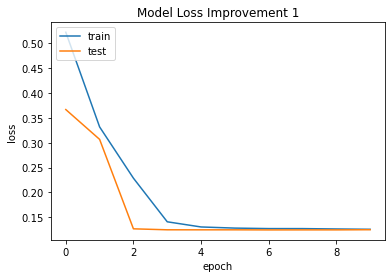

In [31]:
plt.plot(history_imp3.history["loss"])
plt.plot(history_imp3.history["val_loss"])
plt.title("Model Loss Improvement 1")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Save Model

In [32]:
model_imp3.save('best_model.hdf5')

# **7. MODEL INFERENCE**

In [36]:
num_fashion = 50

fashion_list2 = fashion[(fashion['SubCategory']=='Shoes')].ProductId.sample(num_fashion).values     # Mengambil Baju Sembarang Sebanyak 100 lembar
user_1 = np.array([1 for k in range(len(fashion_list2))])

pred = model_imp3.predict([user_1,fashion_list2]).reshape(num_fashion)

top_5_ids = (-pred).argsort()[:5]
top_5_product_id = fashion_list2[top_5_ids]
top_5_product_rating = pred[top_5_ids]*(ratings.rating.max() - ratings.rating.min()) + ratings.rating.min()

2/2 [==============================] - 0s 3ms/step


In [37]:
cek = fashion[(fashion['SubCategory']=='Shoes')].ProductId.sample(num_fashion).values

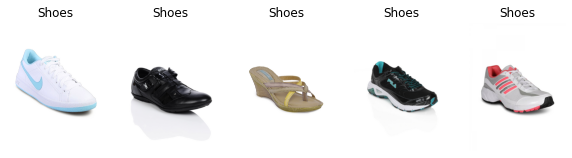

In [39]:
display(HTML('<h2>Lima Product yang Direkomendasikan ke User 1:</h2>'))

fig2,ax2=plt.subplots(ncols=5,figsize=(10,6))
for i,id in enumerate(top_5_product_id):
  a=Image.open(urllib.request.urlopen(fashion['ImageURL'].loc[id]))
  ax2[i].imshow(a)
  ax2[i].set_title('{}'.format(fashion['SubCategory'].loc[id],top_5_product_rating[i]))
  ax2[i].axis('off')

# **8. KESIMPULAN**

## Model

Perlu lebih banyak proses pelatihan untuk mendapatkan hasil yang terbaik, sehingga rekomendasi product yang ditawarkan oleh model lebih sesuai dengan imputan yang diberikan.